Baby's First Reinforcement Learning
----------------------------------------------------

In this notebook we will begin to explore the fundamentals of reinforcement learning. From Wikipedia:

**Reinforcement learning (RL)** is an area of machine learning concerned with how software agents ought to take actions in an environment so as to maximize some notion of cumulative reward. (see: https://en.wikipedia.org/wiki/Reinforcement_learning)

Reinforcement learning has seen numerous successes in recent years. Groups such as OpenAI and
Google Deepmind have successfully trained agents to play Atari games 1 with super-human skill. More recently,
groups have trained agents to play considerably more complex games like Dota II. In each of these cases, the AI
agent is trained by allowing it to explore the environment, and discovering on it’s own which sequences of
actions lead to maximization of the chosen reward.

We will begin by exploring an old idea known as a **Markov Decision Process** (MDP). MDP's can be applied in reinforcement learning contexts, but as we will see they have limitations. If time allows, we will also explore **Deep Reinforcement Learning** which is a collection of newer techniques designed to overcome the limitations of MDP's by using **Neural Networks**.

In [1]:
from importlib import reload #allow us to reload custom modules any time we like with modifications
from IPython.display import clear_output #so we can iteratively update the output without filling the screen
from collections import deque #fast queue implementation
from pprint import pprint
import matplotlib.pyplot as plt
import time
import environment #custom module
import markov_decision_process #custom module
import progress_bar #custom module
reload(environment)
reload(markov_decision_process)
reload(progress_bar)

#Step 1: Set up the environment such that we can view it, modify it, determine rewards
env = environment.Environment()
print("This is what our environment looks like. The Agent 'A' needs to learn to seek out the food/reward 'R'.")
env.render()

This is what our environment looks like. The Agent 'A' needs to learn to seek out the food/reward 'R'.
----------
|R       |  
|        |  
|        |  
|        |  
|    A   |  
|        |  
|        |  
|        |  
----------


In [2]:
#Step 2: Initialize trainable MDP
mdp = markov_decision_process.MarkovDecisionProcess()
mdp.set_possible_actions(env.agent.get_possible_movement_directions())

#Define the observe->action step functionality we use during training
def train_step(env, mdp, epsilon=0.5):
    #Observe the environment (get the current state).
    state = env.get_state_vector(as_string=True) #String is easier for our MDP class to store
    
    #Given the state, select an action.
    action = mdp.get_predicted_action(state, epsilon)
    env.agent.move(action)
    
    #Determine if we got a reward. 
    reward = 0
    if env.has_agent_food_collision():
        reward = 1
        env.reset_food()
        
    return state, action, reward #This will be used by the outer training loop to encourage rewarding actions

#Observe that prior to training the MDP, our agent moves around essentially randomly
for i in range(0,10):
    train_step(env, mdp)
    clear_output()
    env.render()
    time.sleep(0.5)

----------
|R     A |  
|        |  
|        |  
|        |  
|        |  
|        |  
|        |  
|        |  
----------


Progress: [####################] 100.0%


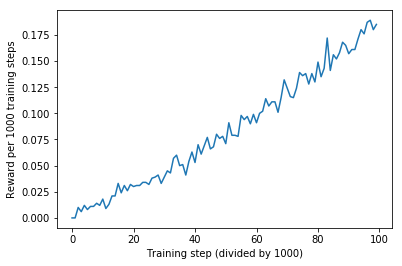

In [3]:
#Step 3: Run MDP training algorithm on the environment from step 1. Observe reward/time curve.
training_steps = 100000
initial_epsilon = 1
epsilon = initial_epsilon 
anneal_epsilon = True #do we decrease epsilon over time?
max_history_length = 10 #how many past actions do we want to encourage?
history = deque([])
progress = progress_bar.ProgressBar(total_elements=training_steps)
reward_trends = []
reward_trend_interval = 1000
cumulative_reward_trend = 0

#This is the main training loop.
for i in range(0, training_steps):
    state, action, reward = train_step(env, mdp, epsilon)
    history.append({"state": state, "action": action})
    while len(history) > max_history_length:
        history.popleft()
        
    if reward > 0:
        for sa in history:
            mdp.encourage(sa["state"], sa["action"])
        cumulative_reward_trend += reward
        
    #We just "turn down" epsilon by a linear interpolation from initial_epsilon to 0.
    if anneal_epsilon:
        epsilon_lerp = initial_epsilon / training_steps
        epsilon = epsilon - epsilon_lerp
        if epsilon < 0:
            epsilon = 0 #might happen due to floating point error stacking up?
            
    if i % reward_trend_interval == 0:
        reward_trends.append(cumulative_reward_trend / reward_trend_interval)
        cumulative_reward_trend = 0
        progress.update(i).draw()
            
progress.update(training_steps).draw()
            
plt.plot(range(len(reward_trends)), reward_trends)
plt.ylabel("Reward per 1000 training steps")
plt.xlabel("Training step (divided by 1000)")
plt.show()

In [4]:
#What do the MDP internal state->action pairs look like?
pprint(mdp.state_actions)

{'00000001': {0: 1404, 1: 1407, 2: 19296, 3: 1261},
 '00000010': {0: 566, 1: 7822, 2: 1047, 3: 631},
 '00000100': {0: 669, 1: 10022, 2: 723, 3: 767},
 '00001000': {0: 459, 1: 846, 2: 483, 3: 7004},
 '00010000': {0: 701, 1: 662, 2: 627, 3: 9627},
 '00100000': {0: 6199, 1: 414, 2: 415, 3: 719},
 '01000000': {0: 2456, 1: 176, 2: 235, 3: 229},
 '10000000': {0: 7033, 1: 486, 2: 838, 3: 436}}


In [5]:
#Observe our agent after training for a while. Does it appear to have learned anything?
for i in range(0,50):
    train_step(env, mdp, epsilon=0)
    clear_output()
    env.render()
    time.sleep(0.5)

----------
|        |  
|        |  
|      A |  
|        |  
|        |  
|        |  
|       R|  
|        |  
----------


Success! What's next?
--------------------------------

Huzzah! Our Markov Decision Process was trained (unless your run was exceptionially unlucky) and can navigate the environment, collecting reward with ease. Where can we go from here?

The logical next step given my goals is to attempt to model the Markov Decision Process with a Neural Network. It would be great if we could just drop in a Neural Network where the MDP was an train it with exactly the same process. Will that work? I'm thinking it should (with some minor tweaks) since neural networks are effectively arbitrary function approximators. Thus, it should be able to learn a simple mapping like the MDP. Let's find out!

In [6]:
#If you do not already have PyTorch, you can download & install it from instructions here:
#https://pytorch.org/get-started/locally/
import torch
import torch.nn as nn
import torch.optim as optim

#This class allows us to quickly and easily build a generic feedforward neural network
#We can make it behave like the MDP by adding the same functions we gave the MDP class
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_function = torch.sigmoid, num_layers = 1):
        super(NeuralNet, self).__init__()
        self.activation_function = activation_function
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        
        if self.num_layers < 1:
            self.num_layers = 1
            print("Zero hidden layers not allowed, defaulted to one.")

        self.layers.append(nn.Linear(self.input_size, self.hidden_size))
        for i in range(0, self.num_layers):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
        self.layers.append(nn.Linear(self.hidden_size, self.output_size))
        
    def forward(self, x):
        for layer in self.layers:
            x = self.activation_function(layer(x))
        return x


input_size = len(env.get_state_vector())
hidden_size = input_size * 4
output_size = len(env.agent.get_possible_movement_directions())
neural_mdp = NeuralNet(input_size, hidden_size, output_size, num_layers = 1) #maybe we'll play with the other parameters later

#how many parameters to train?
pytorch_total_params = sum(p.numel() for p in neural_mdp.parameters() if p.requires_grad)
print("Number of trainable parameters in Neural MDP: ", pytorch_total_params)

Number of trainable parameters in Neural MDP:  1476


In [7]:
import random

#Takes an integer "target" in the range [0, num_classes] and returns the one-hot 
#encoding of that target as a tensor of length num_classes where the value at index
#target is 1.0 and all other values are 0.
def one_hot(target, num_classes):
    one_hot = torch.zeros(num_classes, dtype=torch.float32)
    one_hot[target] = 1.0
    return one_hot

#Define the observe->action step functionality we use during training
def train_step_nn(env, neural_net, epsilon=0.5):
    #Observe the environment (get the current state).
    state = torch.tensor(env.get_state_vector(as_string=False), dtype=torch.float32)
    
    #Given the state, choose an action. Either from the network, or randomly according to epsilon.
    action_predicted = neural_net(state) #We need to get an output from the network either way
    num_possible_directions = len(env.agent.get_possible_movement_directions())
    choice = random.random()
    if choice < epsilon:
        action_taken = one_hot(random.randint(0, num_possible_directions-1), num_possible_directions)
    else:
        action_taken = one_hot(torch.argmax(action_predicted), action_predicted.shape[0]) 
        
    env.agent.move(torch.argmax(action_taken).item())
    
    #Determine if we got a reward. 
    reward = 0
    if env.has_agent_food_collision():
        reward = 1
        env.reset_food()
        
    return state, action_predicted, action_taken, reward #This will be used by the outer training loop to encourage rewarding actions



Before training, let's take a look again at how the agent behaves. It should basically sit still or run in to a wall and stay there. This is because with **epsilon=0** we're giving full control of the agent to the Neural Network, the same network which hasn't learned anything yet! 

In [8]:
#How does the agent move around prior to training the new NN?
#Clearly not the way we want it to!
#The NN's actions are deterministic, we need to add some randomness like the MDP had for training to work!
for i in range(0,10):
    train_step_nn(env, neural_mdp, epsilon=0)
    clear_output()
    env.render()
    time.sleep(0.5)

----------
|        |  
|        |  
|A       |  
|        |  
|        |  
|        |  
|       R|  
|        |  
----------


Progress: [####################] 100.0%


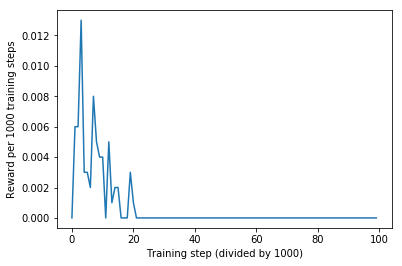

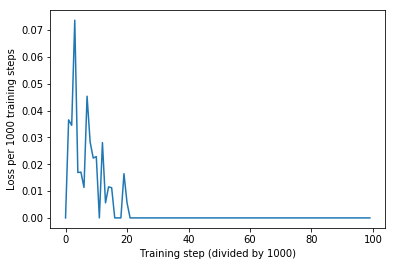

In [9]:
#So let's train the neural network using essentially the same algorithm as before
training_steps = 100000
initial_epsilon = 1
epsilon = initial_epsilon 
anneal_epsilon = True #do we decrease epsilon over time?
max_history_length = 10 #how many past actions do we want to encourage?
history = deque([])
progress = progress_bar.ProgressBar(total_elements=training_steps)
reward_trends = []
loss_trends = []
trend_interval = 1000
cumulative_reward_trend = 0
cumulative_loss_trend = 0

#nn specific setup
criteria = nn.BCELoss()
#optimizer = optim.SGD(neural_mdp.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(neural_mdp.parameters()) #Adam is a pretty "safe"/forgiving optimizer

#This is the main training loop.
for i in range(0, training_steps):
    state, action_predicted, action_taken, reward = train_step_nn(env, neural_mdp, epsilon)
    history.append({"state": state, "action_predicted": action_predicted, "action_taken": action_taken, "reward": reward})
    while len(history) > max_history_length:
        history.popleft()
        
    loss_sum = 0
    if reward > 0: #Only if we got a reward do we backpropogate and adjust any network weights
        for h in history:
            optimizer.zero_grad()
            loss_immediate = criteria(neural_mdp(h["state"]), h["action_taken"])
            loss_immediate.backward(retain_graph=True)
            loss_sum += loss_immediate
            optimizer.step()
            
        cumulative_loss_trend += loss_sum.item()
        cumulative_reward_trend += reward
        
    #We just "turn down" epsilon by a linear interpolation from initial_epsilon to 0.
    if anneal_epsilon:
        epsilon_lerp = initial_epsilon / training_steps
        epsilon = epsilon - epsilon_lerp
        if epsilon < 0:
            epsilon = 0 #might happen due to floating point error stacking up?
            
    if i % trend_interval == 0:
        reward_trends.append(cumulative_reward_trend / trend_interval)
        cumulative_reward_trend = 0
        loss_trends.append(cumulative_loss_trend / trend_interval)
        cumulative_loss_trend = 0
        progress.update(i).draw()
            
progress.update(training_steps).draw()
            
plt.plot(range(len(reward_trends)), reward_trends)
plt.ylabel("Reward per 1000 training steps")
plt.xlabel("Training step (divided by 1000)")
plt.show()

plt.plot(range(len(loss_trends)), loss_trends)
plt.ylabel("Loss per 1000 training steps")
plt.xlabel("Training step (divided by 1000)")
plt.show()

Well...
-------

By looking at the learning curves above, we can already tell that something isn't right.
They don't look at all like the curve from the vanilla MDP implementation! What's going on?

In [10]:
#Observe our agent after training for a while. Does it appear to have learned anything?
for i in range(0,25):
    train_step_nn(env, neural_mdp, epsilon=0)
    clear_output()
    env.render()
    time.sleep(0.5)

----------
|        |  
|        |  
|        |  
|        |  
|      R |  
|A       |  
|        |  
|        |  
----------


This definitely isn't working. At least, it doesn't work using the exact same training methodology. Is there anything we can do to improve this?

First let's examine the network output and see if there might be any clues as to what's going on. 

In [11]:
#What does the output look like for each possible state? Maybe we (humans) can learn something from it...
tensor_list = []
def print_states_predictions(nnmdp):
    for i in range(0,8):
        inp = one_hot(i, 8)
        output = nnmdp(inp) #get the activation for this state, which is a one-hot vector
        tensor_list.append(output)
        print("In: ", inp, " out: ", output)
        
print_states_predictions(neural_mdp)
if tensor_list[0] is tensor_list[1]:
    print("Yeah, they're the same")

In:  tensor([1., 0., 0., 0., 0., 0., 0., 0.])  out:  tensor([0.2093, 0.2125, 0.3100, 0.2762], grad_fn=<SigmoidBackward>)
In:  tensor([0., 1., 0., 0., 0., 0., 0., 0.])  out:  tensor([0.2085, 0.2135, 0.3079, 0.2768], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 1., 0., 0., 0., 0., 0.])  out:  tensor([0.2049, 0.2090, 0.3044, 0.2778], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 1., 0., 0., 0., 0.])  out:  tensor([0.2062, 0.2110, 0.3046, 0.2785], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 1., 0., 0., 0.])  out:  tensor([0.2038, 0.2104, 0.3032, 0.2768], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 0., 1., 0., 0.])  out:  tensor([0.2081, 0.2146, 0.3075, 0.2780], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 0., 0., 1., 0.])  out:  tensor([0.2092, 0.2152, 0.3089, 0.2765], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 0., 0., 0., 1.])  out:  tensor([0.2080, 0.2140, 0.3113, 0.2787], grad_fn=<SigmoidBackward>)


That's quite unusual, each of our states yields the same predicted action! Why is this happening? It's hard to say without diving in to a bunch of math, but we can clearly see that the outputs for each state are very similar and that's NOT what we want. 

As a sanity check, let's make sure the network is actually capable of learning an ideal policy. There are several, but I already know one so let's jut train it directly. 


Progress: [####################] 99.9%


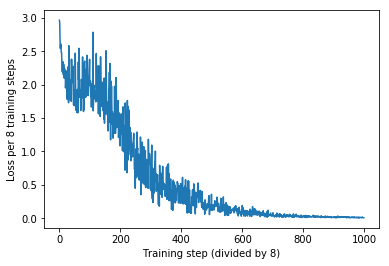

tensor([9.9806e-01, 1.0886e-03, 2.9373e-04, 1.4020e-03], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)
tensor([9.9798e-01, 1.1151e-03, 2.9057e-04, 1.4234e-03], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)
tensor([9.9806e-01, 1.0871e-03, 2.9841e-04, 1.3987e-03], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)
tensor([0.0031, 0.0020, 0.0079, 0.9871], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)
tensor([8.4554e-04, 9.9760e-01, 1.5521e-03, 2.3028e-04], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)
tensor([8.4717e-04, 9.9760e-01, 1.5693e-03, 2.2826e-04], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)
tensor([8.6991e-04, 9.9759e-01, 1.4830e-03, 2.3582e-04], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)
tensor([3.6107e-04, 5.8860e-03, 9.8516e-01, 8.0534e-03], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)


In [12]:
#Let's see if I can just brute force train the network, since the mapping is trivial
#and it will rule out some setting being wrong or other stupid bugs.
neural_mdp = NeuralNet(8, 32, 4, num_layers = 1).double()

criteria = nn.BCELoss()
#optimizer = optim.SGD(neural_mdp.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(neural_mdp.parameters())

training_steps = 1000

progress = progress_bar.ProgressBar(total_elements=training_steps)

state_action_mapping = [
    {"state": torch.tensor([1.0,0,0,0,0,0,0,0], dtype=torch.double), "action": torch.tensor([1.0,0,0,0], dtype=torch.double)},
    {"state": torch.tensor([0,1.0,0,0,0,0,0,0], dtype=torch.double), "action": torch.tensor([1.0,0,0,0], dtype=torch.double)},
    {"state": torch.tensor([0,0,1.0,0,0,0,0,0], dtype=torch.double), "action": torch.tensor([1.0,0,0,0], dtype=torch.double)},
    {"state": torch.tensor([0,0,0,1.0,0,0,0,0], dtype=torch.double), "action": torch.tensor([0,0,0,1.0], dtype=torch.double)},
    {"state": torch.tensor([0,0,0,0,1.0,0,0,0], dtype=torch.double), "action": torch.tensor([0,1.0,0,0], dtype=torch.double)},
    {"state": torch.tensor([0,0,0,0,0,1.0,0,0], dtype=torch.double), "action": torch.tensor([0,1.0,0,0], dtype=torch.double)},
    {"state": torch.tensor([0,0,0,0,0,0,1.0,0], dtype=torch.double), "action": torch.tensor([0,1.0,0,0], dtype=torch.double)},
    {"state": torch.tensor([0,0,0,0,0,0,0,1.0], dtype=torch.double), "action": torch.tensor([0,0,1.0,0], dtype=torch.double)},
]
loss_log = []
for i in range(0, training_steps):
    avg_loss = 0
    for k in range(0,8):
        #TODO unroll this loop and make sure nothing funny happens
        j = state_action_mapping[random.randint(0, len(state_action_mapping)-1)]
        optimizer.zero_grad()
        out = neural_mdp(j["state"])
        loss = criteria(out, j["action"])
        loss.backward()
        avg_loss += loss.item()
        optimizer.step()
    avg_loss = avg_loss / len(j)
    loss_log.append(avg_loss)
    progress.update(i).draw()

plt.plot(range(len(loss_log)), loss_log)
plt.ylabel("Loss per 8 training steps")
plt.xlabel("Training step (divided by 8)")
plt.show()

for s in state_action_mapping:
    pprint(neural_mdp(s['state']).double())

#Beautiful! So yes, the network is clearly *capable* of learning the mapping.


What if we kept a history of all the sequences that led to a reward? A sort of... memory of good experiences?
This is basically what DeepMind did in their paper "Playing Atari with Deep Reinforcement Learning".
They're using a different algorithm (based on more typical Q-learning) but perhaps we just need to have more
good examples to train the network on? That should provide some insight in any case.

**Forewarning**: This algorithm will take quite some time to run, possibly more than an hour if you're on a laptop or slow computer.

Progress: [####################] 100.0%


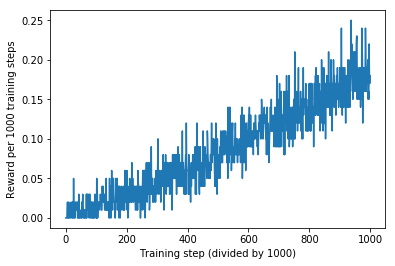

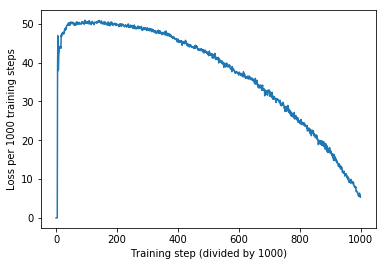

In [13]:
#Reinitialize the Neural Network so that it has random weights and we aren't starting from a bad spot.
neural_mdp = NeuralNet(input_size, hidden_size, output_size, num_layers = 1) #maybe we'll play with the other parameters later

#Modify our algorithm to keep a buffer of past state->action sequences that ended in a reward.
training_steps = 100000
initial_epsilon = 1
epsilon = initial_epsilon 
anneal_epsilon = True #do we decrease epsilon over time?
max_history_length = 10 #how many past actions do we want to encourage?
history = deque([])
max_replay_memory = 1000 #Keep this many "positive" sequences to reinforce from
replay_memory = deque([])
progress = progress_bar.ProgressBar(total_elements=training_steps)
reward_trends = []
loss_trends = []
trend_interval = 100
cumulative_reward_trend = 0
cumulative_loss_trend = 0

#nn specific setup
criteria = nn.BCELoss()
optimizer = optim.Adam(neural_mdp.parameters()) #Adam is a pretty "safe"/forgiving optimizer

#This is the main training loop.
for i in range(0, training_steps):
    state, action_predicted, action_taken, reward = train_step_nn(env, neural_mdp, epsilon)
    state_action_reward = {"state": state, "action_predicted": action_predicted, "action_taken": action_taken, "reward": reward} 
    history.append(state_action_reward)
    while len(history) > max_history_length:
        history.popleft()
        
    loss_sum = 0
    if reward > 0:
        replay_memory.append(history.copy()) #must make a copy becase otherwise altering history alters everything in here
        while len(replay_memory) > max_replay_memory:
            replay_memory.popleft()
            
    cumulative_reward_trend += reward
            
    #Here's where the actual training happens. We select a random successful sequence state->action transition
    #from the replay memory at every step and backpropogate + update weights from it.
    loss_sum = 0
    if len(replay_memory) > 0:
        for j in range(0,100):
            successful_sequence = replay_memory[random.randint(0, len(replay_memory) - 1)]
            optimizer.zero_grad()
            h = successful_sequence[random.randint(0, len(successful_sequence)-1)]
            loss = criteria(neural_mdp(h["state"]), h["action_taken"])
            loss_sum += loss
            loss.backward(retain_graph=True)
            optimizer.step()
        cumulative_loss_trend += loss_sum.item()
        
    #We just "turn down" epsilon by a linear interpolation from initial_epsilon to 0.
    if anneal_epsilon:
        epsilon = initial_epsilon - (i / training_steps)
            
    if i % trend_interval == 0:
        reward_trends.append(cumulative_reward_trend / trend_interval)
        cumulative_reward_trend = 0
        progress.update(i).draw()
        loss_trends.append(cumulative_loss_trend / trend_interval)
        print("Loss: ", cumulative_loss_trend)
        cumulative_loss_trend = 0
            
progress.update(training_steps).draw()
            
plt.plot(range(len(reward_trends)), reward_trends)
plt.ylabel("Reward per 1000 training steps")
plt.xlabel("Training step (divided by 1000)")
plt.show()

plt.plot(range(len(loss_trends)), loss_trends)
plt.ylabel("Loss per 1000 training steps")
plt.xlabel("Training step (divided by 1000)")
plt.show()

In [14]:
#What does the output look like for each possible state? Maybe we (humans) can learn something from it...
def print_states_predictions(nnmdp):
    for i in range(0,8):
        inp = one_hot(i, 8)
        output = nnmdp(inp) #get the activation for this state, which is a one-hot vector
        print("In: ", inp, " out: ", output)
        
print_states_predictions(neural_mdp)

In:  tensor([1., 0., 0., 0., 0., 0., 0., 0.])  out:  tensor([0.9799, 0.0033, 0.0089, 0.0024], grad_fn=<SigmoidBackward>)
In:  tensor([0., 1., 0., 0., 0., 0., 0., 0.])  out:  tensor([0.9808, 0.0039, 0.0103, 0.0028], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 1., 0., 0., 0., 0., 0.])  out:  tensor([0.0119, 0.0030, 0.0046, 0.9803], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 1., 0., 0., 0., 0.])  out:  tensor([0.0053, 0.0082, 0.0349, 0.9731], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 1., 0., 0., 0.])  out:  tensor([0.0024, 0.0015, 0.0012, 0.9874], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 0., 1., 0., 0.])  out:  tensor([0.0080, 0.9854, 0.0041, 0.0024], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 0., 0., 1., 0.])  out:  tensor([1.1483e-03, 3.7157e-03, 9.8759e-01, 1.5264e-04],
       grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 0., 0., 0., 1.])  out:  tensor([0.0066, 0.0068, 0.9807, 0.0041], grad_fn=<SigmoidBackward>)


In [ ]:
#Observe our agent after training for a while. Does it appear to have learned anything?
for i in range(0,25):
    train_step_nn(env, neural_mdp, epsilon=0)
    clear_output()
    env.render()
    time.sleep(0.5)